In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import diffrax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import equinox as eqx
import optax
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm
from models.fno_model import FNO1d
from jax import random
from scipy.integrate import solve_ivp
import numpy as np


/var/folders/dj/9l55bm1s047crb4scq4r44vh0000gn/T/ipykernel_51116/3699643535.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:

def create_noise(r_min, r_max, num_steps_r, f_min, f_max, num_steps_f, key):  #frequency noch rein
    N_r = int(num_steps_r)
    N_f = int(num_steps_f)

    r = jnp.linspace(r_min, r_max, N_r) 
    f = jnp.linspace(f_min, f_max, N_f) 

    #create noise 
    amplitude = 1e2

    # Frequencies: cycles per unit length
    k = jnp.fft.fftfreq(N_r, d=amplitude*(r_max - r_min)/ N_r)   # im Skript aus dem ich das habe ist statt r_max-r_min einfach L und r geht von 0 bis L -> passt das trotzdem?

    # Desired frequency peak and spread
    f0 = 0.05           # Peak frequency in 1/m
    sigma = 0.05       # Spread in frequency


    # Build power spectrum: symmetric Gaussian around ±f0
    P = jnp.exp(-0.5 * ((k - f0) / sigma)**2) + jnp.exp(-0.5 * ((k + f0) / sigma)**2)

    # Random phases only for positive frequencies
    random_phases = jnp.exp(2j * jnp.pi * random.uniform(key, (N_f, N_r)))
    

    # Fourier coefficients: amplitude * phase
    fourier_noise = jnp.sqrt(P) * random_phases

    # Hermitian symmetry (for real IFFT)
    # Set DC and Nyquist real
    fourier_noise = fourier_noise.at[:,0].set(0)
    fourier_noise = fourier_noise.at[:, N_r//2].set(fourier_noise[:, N_r//2].real)

    # Mirror positive frequencies to negative frequencies
    for i in range(1, N_r//2):
        fourier_noise = fourier_noise.at[:, -i].set(jnp.conj(fourier_noise[:, i]))

    # Inverse FFT to real space
    noise = jnp.fft.ifft(fourier_noise).real * 500
    return noise


def create_a(r_min, r_max, num_steps_r, f_min, f_max, num_steps_f, K, p):
    N_r = int(num_steps_r)
    N_f = int(num_steps_f)
    r = jnp.linspace(r_min, r_max, N_r) 
    f = jnp.linspace(f_min, f_max, N_f) 
    R, F = jnp.meshgrid(r, f)   # this results in an output where each row is for constant frequency (same as in create_j)
    return K*R**p   #frequency dependence noch reinbringen -> alternative K und p abhägnig von Frequenz machen und 
    # evtl wie bei create noise zwei mal vmappen, einmal um  pro frequency verschiede a = Kr**p zu bekommen und dann nochmal für 
    # mehrere Trainingsdaten (d.h. K und p sind dann zweidimensionale inputs und nicht wie jetzt 1-D arrays)

  
def create_j(r_min, r_max, num_steps_r, f_min, f_max, num_steps_f, j_start):
    N_r = int(num_steps_r)
    N_f = int(num_steps_f)
    r = jnp.linspace(r_min, r_max, N_r) 
    f = jnp.linspace(f_min, f_max, N_f) 
    j = jnp.zeros((num_steps_f, num_steps_r))
    j = j.at[:,0].set(j_start)
    return j


create_noise_vmap = jax.vmap(create_noise, in_axes=(None, None, None, None, None, None, 0)) 
create_a_vmap = jax.vmap(create_a, in_axes=(None, None, None, None, None, None, 0, 0)) 
create_j_vmap = jax.vmap(create_j, in_axes=(None, None, None, None, None, None, 0)) 

In [3]:
# Testing

#js = jnp.ones(10)
#result = create_j_vmap(0.1, 1.0, 2000, 1.0, 2.0, 10, js)
#
#Ks = jnp.ones(10)
#ps = jnp.ones(10)
#result2 = create_a_vmap(0.1, 1.0, 2000, 1.0, 2.0, 10, Ks, ps)
#
#key = random.PRNGKey(0)
#keys = random.split(key, 10)
#result3 = create_noise_vmap(0.1, 1.0, 2000, 1.0, 2.0, 10, keys)


In [4]:
# So far we've got fuctions to create a(f,r) + e(f,r) and j(f,r), now we need to compute I(r,f) from them

In [14]:
def determine_I_single_f(r_min, r_max, num_steps_r, a, j):
    # vllt noch implementieren, dass gecheckt, dass a,e,j auf gleichem Intervall und mit gleicher Anzahl steps definiert
    N_r = int(num_steps_r)
    r_lin = jnp.linspace(r_min, r_max, N_r) 

    dr = r_lin[1] - r_lin[0]

    def f(r, I):
        a_value = jnp.maximum(a[int(r//dr - r_lin[0]//dr)], 0) # a below 0 is not possible
        j_value = jnp.maximum(j[int(r//dr - r_lin[0]//dr)], 0) # j below 0 is not possible
        #print(a, j)
        if r == r_lin[0]:
            return -(a_value/2 + 1/r)*I + j_value/2
        else:
            return -(a_value/2 + 1/r)*I
        
    def rk4_step(r, I, dr):
        k1 = f(r, I)
        k2 = f(r + dr / 2, I + dr / 2 * k1)
        k3 = f(r + dr / 2, I + dr / 2 * k2)
        k4 = f(r + dr, I + dr * k3)
        
        return I + (dr / 6) * (k1 + 2*k2 + 2*k3 + k4)

    I = jnp.zeros(N_r//2)
    I = I.at[0].set(1.)  


    for i in range(int(N_r//2 - 1)):
        I = I.at[i + 1].set(rk4_step( r_lin[2*i], I[i], 2*dr))

    return I 


determine_I_single = jax.vmap(determine_I_single_f, in_axes=(None, None, None, 0, 0))


def determine_I(r_min, r_max, num_steps_r, a, j):
    return determine_I_single(r_min, r_max, num_steps_r, a, j)

determine_I = jax.vmap(determine_I_single, in_axes=(None, None, None, 0, 0))


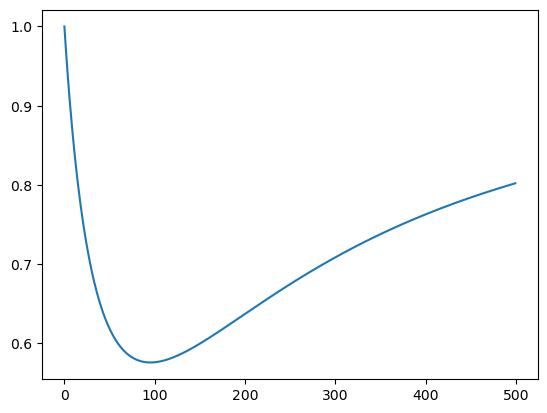

In [16]:
# noch testen, ob die I-Funktionen alle richtig funktionieren (also ob aufeinanderfolgende unterschiedlich und ob richtige Lösung bspw wenn  a und j einfach überall 1 und else term auch j enthält wie if)

In [7]:
# together in create data function

In [31]:
def create_data(r_min, r_max, num_steps_r, f_min, f_max, num_steps_f, key, num_samples):
    # die ganzen noch mit einem key random in trainingsrange erzeugen - key vorher schon splitten und dann ersten 3 teile für das folgende und 4 teil dann bei aufruf noise
    keys = random.split(key, 3)
    js = random.uniform(keys[0], (num_samples,num_steps_f), minval=0, maxval=100) # -> jetzt gerade frequency dependence random, dass natürlich ändern
    Ks = jnp.ones(num_samples)
    ps = random.uniform(keys[1], num_samples, minval=-2, maxval=-1)
    #js = jnp.ones(num_samples)
    #Ks = jnp.ones(num_samples)
    #ps = jnp.ones(num_samples)
    j_train = create_j_vmap(r_min, r_max, num_steps_r, f_min, f_max, num_steps_f, js)
    a_train = create_a_vmap(r_min, r_max, num_steps_r, f_min, f_max, num_steps_f, Ks, ps)
    keys_noise = random.split(keys[2], num_samples)
    noise_train = create_noise_vmap(r_min, r_max, num_steps_r, f_min, f_max, num_steps_f, keys_noise)

    a_noisy_train = a_train + noise_train

    I_train = determine_I(r_min, r_max, num_steps_r, a_noisy_train, j_train)

    return j_train, a_train, a_noisy_train, I_train
    

In [32]:
key = random.PRNGKey(0)
results = create_data(0.1, 1.0, 2000, 0.1, 1.0, 2000, key, 2)

In [52]:
results[1][0]

Array([[98.33456  , 97.458244 , 96.593605 , ...,  1.0017966,  1.0008978,
         1.       ],
       [98.33456  , 97.458244 , 96.593605 , ...,  1.0017966,  1.0008978,
         1.       ],
       [98.33456  , 97.458244 , 96.593605 , ...,  1.0017966,  1.0008978,
         1.       ],
       ...,
       [98.33456  , 97.458244 , 96.593605 , ...,  1.0017966,  1.0008978,
         1.       ],
       [98.33456  , 97.458244 , 96.593605 , ...,  1.0017966,  1.0008978,
         1.       ],
       [98.33456  , 97.458244 , 96.593605 , ...,  1.0017966,  1.0008978,
         1.       ]], dtype=float32)

In [53]:
# noch mit  mit interpolate und ivp solve bzw diffrax. ...


In [10]:
# umschreiben s.d. jnp statt np